In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 999)

In [2]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostRegressor

In [3]:
df = pd.read_csv('Fire_Dep_Call_50%.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
cols = ['Available DtTm', 'Response DtTm', 'Dispatch DtTm', 'Received DtTm', 'On Scene DtTm']
for col in cols:
    df[col] = pd.to_datetime(df[col], format='%m/%d/%Y %I:%M:%S %p', infer_datetime_format=True)

df['On Scene to Available'] = df['Available DtTm'] - df['On Scene DtTm']
df['Call to Dispatch'] = df['Dispatch DtTm'] - df['Received DtTm']
df['Dispatch to Respond'] = df['Response DtTm'] - df['Dispatch DtTm']


time_cols = ['On Scene to Available', 'Call to Dispatch', 'Dispatch to Respond']
df[time_cols] = df[time_cols].applymap(lambda t: t.total_seconds())
df[time_cols] = df[time_cols].applymap(lambda x: max(x,0))

In [5]:
df['Month'] = df['Received DtTm'].dt.month
df['WeekDay'] = df['Received DtTm'].dt.weekday
df['Weekofyear'] = df['Received DtTm'].dt.weekofyear
df['Hours'] = df['Received DtTm'].dt.hour
df['Minutes'] = df['Received DtTm'].dt.minute

#---------added----------columns for hospital or transport
df['Hospital or Transport'] = (~(df['Transport DtTm'].isna() & df['Hospital DtTm'].isna())).astype('int')

In [7]:
def fill_na(df):
    q = df['Original Priority'].value_counts(normalize=True) #counts share of valeus in col w/o N/A
    orig_prio_list = q.index.tolist()  #makes indeces(priorities types) to a list
    orig_prio_shares = q.tolist() #makes values of shares a list
    df['Original Priority'] = df['Original Priority'].fillna(pd.Series(np.random.choice(orig_prio_list, p=orig_prio_shares, size=len(df))))

    w = df['Call Type Group'].value_counts(normalize=True) #counts share of values in col w/o N/A
    call_types_list = w.index.tolist()  #makes indeces(priorities types) to a list
    call_types_shares = w.tolist() #makes values of shares a list
    df['Call Type Group'] = df['Call Type Group'].fillna(pd.Series(np.random.choice(call_types_list, p=call_types_shares, size=len(df))))
    
fill_na(df)

if((df['Zipcode of Incident'].nunique()) <= (df['Neighborhooods - Analysis Boundaries'].nunique())):
    zipcodes = df[['Neighborhooods - Analysis Boundaries','Zipcode of Incident']]
    zipcodes = zipcodes[zipcodes['Zipcode of Incident'].notnull()]
    zips= list(zipcodes['Zipcode of Incident'].values)
    nbhds= list(zipcodes['Neighborhooods - Analysis Boundaries'].values)
    if len(zips) == len(nbhds):
        zipcodes_dict=dict(zip(nbhds,zips))

    else: 
        print('Count unique zipcodes != count neighborhooods, something went wrong.')
else:
    print('More zipcodes than neighborhooods, we need new strategy!')

df['Zipcode of Incident'] = df['Zipcode of Incident'].fillna(df['Neighborhooods - Analysis Boundaries'].map(zipcodes_dict))
df['Zipcode of Incident'] = df['Zipcode of Incident'].astype(int)

In [73]:
df1 = df[(df['On Scene to Available'].notnull()) & (df['On Scene to Available'] <= 30000)  & (df['On Scene to Available']!=0)]

#only not null, not zero and less 10 hours
#(df['Respond to Available'] <= 36000) 

In [74]:
#------cancelled d
df1 = df1.drop(columns=['Call Number','Unit ID', 'Incident Number', 'Call Date', 'Watch Date', 
                      'Received DtTm', 'Entry DtTm', 'Dispatch DtTm','Response DtTm', 'On Scene DtTm',
                      'Transport DtTm','Hospital DtTm', 'Call Final Disposition', 'Available DtTm',
                      'Address', 'City', 'Priority', 'Final Priority', 'Neighborhooods - Analysis Boundaries', 
                       'Location', 'RowID', 'Battalion', 'ALS Unit', 'Weekofyear','Month', 'WeekDay', 'Minutes',
                        'Original Priority', 'Station Area', 'Call Type Group',
                      'Fire Prevention District', 'Supervisor District'], errors='ignore')

In [75]:
df1 = df1.dropna(how='any') 

In [78]:
df1.head()

,Call Type,Zipcode of Incident,Box,Number of Alarms,Unit Type,Unit sequence in call dispatch,On Scene to Available,Call to Dispatch,Dispatch to Respond,Hours,Hospital or Transport
1,Medical Incident,94122,7651.0,1,MEDIC,2,3861.0,87.0,102.0,21,1
3,Alarms,94102,1456.0,1,ENGINE,3,247.0,26.0,105.0,21,0
4,Medical Incident,94108,1322.0,1,RESCUE SQUAD,2,28.0,101.0,116.0,21,0
5,Citizen Assist / Service Call,94109,1463.0,1,TRUCK,1,842.0,43.0,120.0,21,0
6,Electrical Hazard,94109,3155.0,1,ENGINE,1,498.0,171.0,73.0,21,0


In [79]:
y = df1['On Scene to Available']
X = df1.drop(columns=['On Scene to Available'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [80]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1127231 entries, 1 to 1664516
Data columns (total 10 columns):
Call Type                         1127231 non-null object
Zipcode of Incident               1127231 non-null int64
Box                               1127231 non-null float64
Number of Alarms                  1127231 non-null int64
Unit Type                         1127231 non-null object
Unit sequence in call dispatch    1127231 non-null int64
Call to Dispatch                  1127231 non-null float64
Dispatch to Respond               1127231 non-null float64
Hours                             1127231 non-null int64
Hospital or Transport             1127231 non-null int64
dtypes: float64(3), int64(5), object(2)
memory usage: 94.6+ MB


In [81]:
cat_features=[
    0,
    4
]

In [82]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, cat_features=cat_features)

In [83]:
model = CatBoostRegressor(iterations=300, depth=5,learning_rate=0.07)
model.fit(train_pool)

0:	learn: 2026.1305222	total: 816ms	remaining: 4m 3s
1:	learn: 1928.4008914	total: 1.28s	remaining: 3m 10s
2:	learn: 1839.7170215	total: 2.03s	remaining: 3m 21s
3:	learn: 1759.2719155	total: 3.03s	remaining: 3m 44s
4:	learn: 1686.5223902	total: 3.63s	remaining: 3m 33s
5:	learn: 1620.9441949	total: 4.42s	remaining: 3m 36s
6:	learn: 1562.0156668	total: 5.21s	remaining: 3m 38s
7:	learn: 1508.9778492	total: 5.73s	remaining: 3m 29s
8:	learn: 1461.5171535	total: 6.21s	remaining: 3m 20s
9:	learn: 1419.1429819	total: 6.8s	remaining: 3m 17s
10:	learn: 1381.3854416	total: 7.2s	remaining: 3m 9s
11:	learn: 1347.8776193	total: 7.64s	remaining: 3m 3s
12:	learn: 1318.0230060	total: 8.1s	remaining: 2m 58s
13:	learn: 1289.7892298	total: 8.53s	remaining: 2m 54s
14:	learn: 1264.6777854	total: 9.02s	remaining: 2m 51s
15:	learn: 1242.4920179	total: 9.36s	remaining: 2m 46s
16:	learn: 1222.9385948	total: 9.84s	remaining: 2m 43s
17:	learn: 1205.6934953	total: 10.3s	remaining: 2m 41s
18:	learn: 1190.4866813	to

150:	learn: 1049.8104721	total: 1m 22s	remaining: 1m 21s
151:	learn: 1049.6172894	total: 1m 22s	remaining: 1m 20s
152:	learn: 1049.4678743	total: 1m 23s	remaining: 1m 20s
153:	learn: 1049.4015727	total: 1m 24s	remaining: 1m 19s
154:	learn: 1049.3468705	total: 1m 24s	remaining: 1m 19s
155:	learn: 1049.0684459	total: 1m 24s	remaining: 1m 18s
156:	learn: 1049.0273227	total: 1m 25s	remaining: 1m 17s
157:	learn: 1048.8995976	total: 1m 25s	remaining: 1m 17s
158:	learn: 1048.8007272	total: 1m 26s	remaining: 1m 16s
159:	learn: 1048.6646867	total: 1m 26s	remaining: 1m 16s
160:	learn: 1048.5956315	total: 1m 27s	remaining: 1m 15s
161:	learn: 1048.5378842	total: 1m 27s	remaining: 1m 14s
162:	learn: 1048.4581132	total: 1m 28s	remaining: 1m 14s
163:	learn: 1048.4194116	total: 1m 28s	remaining: 1m 13s
164:	learn: 1048.3689321	total: 1m 29s	remaining: 1m 13s
165:	learn: 1048.2838652	total: 1m 29s	remaining: 1m 12s
166:	learn: 1048.2335181	total: 1m 30s	remaining: 1m 11s
167:	learn: 1048.1901608	total:

297:	learn: 1039.3860386	total: 2m 42s	remaining: 1.09s
298:	learn: 1039.3713722	total: 2m 43s	remaining: 547ms
299:	learn: 1039.2387035	total: 2m 44s	remaining: 0us


In [84]:
model.score(test_pool, y_test)  #rmse score. 

1001.8113025415801

In [85]:
pred = model.predict(test_pool)

In [86]:
XYY = X_test.copy()
XYY['y_test'] = y_test
XYY['y_pred'] = pred
XYY['y_test-y_pred'] = XYY['y_test']-XYY['y_pred']
XYY['y_test-y_pred_squared'] = XYY['y_test-y_pred']**2
mean_y = XYY['y_pred'].mean()
XYY['mean_y'] = mean_y
XYY['diff'] = XYY['y_test']-XYY['mean_y']
XYY.head(3)

,Call Type,Zipcode of Incident,Box,Number of Alarms,Unit Type,Unit sequence in call dispatch,Call to Dispatch,Dispatch to Respond,Hours,Hospital or Transport,y_test,y_pred,y_test-y_pred,y_test-y_pred_squared,mean_y,diff
1664518,Structure Fire,94112,8263.0,1,ENGINE,1,40.0,37.0,12,0,44.0,774.523991,-730.523991,533665.301376,1466.06557,-1422.06557
1664521,Medical Incident,94115,3541.0,1,ENGINE,1,102.0,220.0,12,0,652.0,794.637715,-142.637715,20345.517773,1466.06557,-814.06557
1664524,Alarms,94109,1625.0,1,ENGINE,1,52.0,61.0,12,0,591.0,452.790966,138.209034,19101.737094,1466.06557,-875.06557


In [87]:
mae = (abs(XYY['y_test-y_pred']).sum())/len(XYY['y_test-y_pred'])
mse = (XYY['y_test-y_pred']**2).sum()/len(XYY['y_test-y_pred'])
rmse = mse**0.5
determanation_score = 1-((XYY['y_test-y_pred']**2).sum())/((XYY['diff']**2).sum())

In [96]:
mae

617.0563034652848

In [98]:
mse

1003625.8859000573

In [90]:
rmse

1001.8113025415801

In [91]:
determanation_score

0.6216254136773545

In [50]:
#scores compare to mean
total_mean = y_train.mean()
mae_mean = (abs(XYY['y_test']-total_mean).sum())/len(XYY['y_test-y_pred'])
print('mae_mean: '+ str(mae_mean))
mse_mean = ((XYY['y_test']-total_mean)**2).sum()/len(XYY['y_test-y_pred'])
print('mse_mean: '+ str(mse_mean))
rmse_mean = mse_mean**0.5
print('mrse_mean: '+ str(rmse_mean))

mae_mean: 1306.9332468946413
mse_mean: 2933754.717806271
mrse_mean: 1712.820690500401


In [92]:
val = model.get_feature_importance()
feat = X_test.columns

list(zip(feat,val))

[('Call Type', 2.882022215321412),
 ('Zipcode of Incident', 1.4040424286849649),
 ('Box', 2.0526352121421723),
 ('Number of Alarms', 12.402517761270108),
 ('Unit Type', 5.846063753488031),
 ('Unit sequence in call dispatch', 2.5608182076554664),
 ('Call to Dispatch', 1.1608316991002354),
 ('Dispatch to Respond', 2.4740677320884616),
 ('Hours', 1.621410652897152),
 ('Hospital or Transport', 67.59559033735201)]

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline

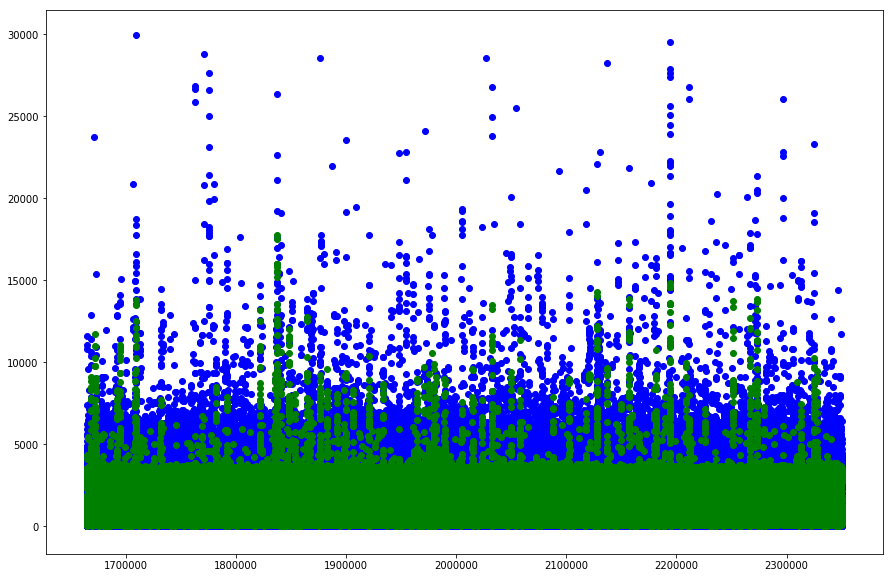

In [94]:
XYY = XYY.sort_values('y_test')
plt.figure(figsize=(15,10))
plt.scatter(XYY.index, XYY['y_test'].sort_values(), color='b')
plt.scatter(XYY.index, XYY['y_pred'], color='g')
plt.show()

In [57]:
y_train.sort_values()

842790         1.0
728963         1.0
1494980        1.0
412998         1.0
1203326        1.0
412961         1.0
86863          1.0
5085           1.0
833880         1.0
833882         1.0
98282          1.0
605596         1.0
1264307        1.0
284705         1.0
945352         1.0
1217738        1.0
373575         1.0
993846         1.0
571450         1.0
850765         1.0
292804         1.0
850764         1.0
850763         1.0
639723         1.0
850761         1.0
447295         1.0
1039249        1.0
467458         1.0
67827          1.0
1525705        1.0
            ...   
1197106    30245.0
1549183    30314.0
909507     30341.0
655547     30554.0
1197149    30585.0
911475     30593.0
272752     30698.0
614851     30845.0
655522     31130.0
909472     31204.0
909471     31637.0
909508     31774.0
909483     31898.0
1197150    32180.0
1549184    32245.0
427276     32363.0
1197110    32436.0
290417     32486.0
909482     33212.0
113914     33348.0
303646     33622.0
1351362    3